# Logistic Regression Model Development
### Using Generative AI to build the model
Trainer : - Rajesh Jakhtoia

# Prompt to build the Logistic Regression Model
I want to build a Logistic Regression Model using Python Programming on dataset named LR_DF.
The target variable is "Target" and predictor variables are Age, Gender, Balance, Occupation, No_OF_CR_TXNS, AGE_BKT, SCR, Holding_Period. 
Give me code in the following steps:
1. Import data from file named DEV_Sample.csv
2. Cust_ID is the Identifier Column.
3. Calculate the information value (IV) for both continuous and categorical independent variables. Display IV in a tabular format.
4. Perform One-Hot encoding for the categorical variables. Drop special characters other than _ from the variable names.
5. Convert Boolean columns to numeric 1/0 values
6. Build the model using StatsModel package and show the Model Summary. Do not add a constant column. The StatsModel package will automatically take care of it.
7. Check for Multi-collinearity. 
8. Show the AUC and KS as model performance measures.

Information Value for each variable in tabular format:
         Variable        IV
0  Holding_Period  0.614921
1   No_OF_CR_TXNS  0.210799
2      Occupation  0.125124
3         Balance  0.113119
4             SCR  0.084419
5             Age  0.051475
6         AGE_BKT  0.042904
7          Gender  0.013426
Target                  int64
Age                     int64
Balance               float64
No_OF_CR_TXNS           int64
SCR                     int64
Holding_Period          int64
Gender_M                int32
Gender_O                int32
Occupation_SAL          int32
Occupation_SELFEMP      int32
Occupation_SENP         int32
AGE_BKT_3135            int32
AGE_BKT_3640            int32
AGE_BKT_4145            int32
AGE_BKT_4650            int32
AGE_BKT_25              int32
AGE_BKT_50              int32
dtype: object
Model Summary:
                 Generalized Linear Model Regression Results                  
Dep. Variable:                 Target   No. Observations:                14

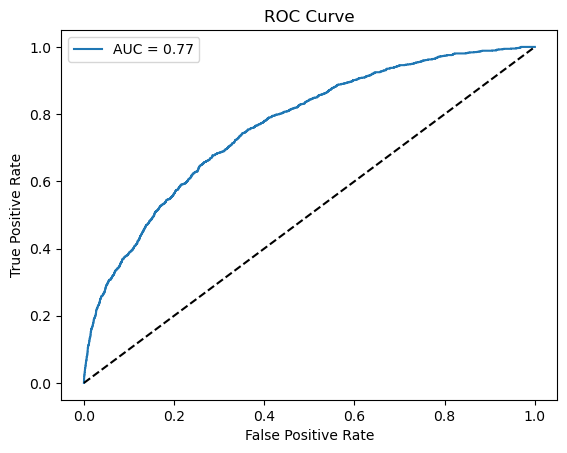

KS Statistic: 0.39226471674984265


In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import glm
from statsmodels.genmod.families import Binomial
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import re

# Step 1: Import data from file
file_path = 'DEV_Sample.csv'
LR_DF = pd.read_csv(file_path)

# Step 2: Cust_ID is the Identifier Column
LR_DF = LR_DF.drop(columns=['Cust_ID'])

# Step 3: Calculate the information value for both continuous and categorical independent variables
def calculate_iv(df, feature, target, bins=10):
    temp_df = df.copy()
    if pd.api.types.is_numeric_dtype(temp_df[feature]):
        temp_df[feature], bins = pd.qcut(temp_df[feature], bins, retbins=True, duplicates='drop')
    cross_tab = pd.crosstab(temp_df[feature], temp_df[target], normalize='columns')
    cross_tab['Distr_Good'] = cross_tab[0]
    cross_tab['Distr_Bad'] = cross_tab[1]
    cross_tab['WoE'] = np.log(cross_tab['Distr_Good'] / cross_tab['Distr_Bad']).replace([-np.inf, np.inf], 0)
    cross_tab['IV'] = (cross_tab['Distr_Good'] - cross_tab['Distr_Bad']) * cross_tab['WoE']
    iv = cross_tab['IV'].sum()
    return iv

def calculate_iv_for_dataset(df, target, bins=10):
    iv_dict = {}
    for col in df.columns:
        if col != target:
            iv_value = calculate_iv(df, col, target, bins)
            iv_dict[col] = iv_value
    return iv_dict

iv_values = calculate_iv_for_dataset(LR_DF, 'Target')
iv_df = pd.DataFrame(list(iv_values.items()), columns=['Variable', 'IV'])
iv_df = iv_df.sort_values(by='IV', ascending=False).reset_index(drop=True)

print("Information Value for each variable in tabular format:")
print(iv_df)

# Step 4: Perform One-Hot encoding for the categorical variables. Drop special characters other than _ from the variable names
LR_DF = pd.get_dummies(LR_DF, columns=['Gender', 'Occupation', 'AGE_BKT'], drop_first=True)

# Clean the column names by removing special characters other than _
LR_DF.columns = [re.sub(r'[^a-zA-Z0-9_]', '', col) for col in LR_DF.columns]

# Step 5: Convert Boolean columns to numeric 1/0 values
bool_cols = LR_DF.select_dtypes(include=['bool']).columns
LR_DF[bool_cols] = LR_DF[bool_cols].astype(int)

# Ensure all columns are numeric
LR_DF = LR_DF.apply(pd.to_numeric, errors='coerce')

# Handle missing values (e.g., fill with 0 or mean of the column)
LR_DF = LR_DF.fillna(0)

# Ensure there are no non-finite values
LR_DF = LR_DF.replace([np.inf, -np.inf], np.nan).dropna()

# Validate data types
print(LR_DF.dtypes)

# Step 6: Build the model using StatsModel package and show the Model Summary. Do not add a constant column
X = LR_DF.drop('Target', axis=1)
y = LR_DF['Target']

formula = 'Target ~ ' + ' + '.join(X.columns)
model = glm(formula=formula, data=LR_DF, family=Binomial()).fit()

print("Model Summary:")
print(model.summary())

# Step 7: Check for Multi-collinearity
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    # Ensure all data is numeric
    X = X.apply(pd.to_numeric, errors='coerce')
    X = X.replace([np.inf, -np.inf], np.nan).dropna()
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

vif_data = calculate_vif(X)
print("Variance Inflation Factor for each feature:")
print(vif_data)

# Step 8: Show the AUC and KS as model performance measures
y_pred_prob = model.predict(X)

# Calculate AUC
auc = roc_auc_score(y, y_pred_prob)
print(f'AUC: {auc}')

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y, y_pred_prob)
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

# Calculate KS statistic
ks = max(tpr - fpr)
print(f'KS Statistic: {ks}')


## Visualization and Pattern Detection

# Prompt for Visualization and Pattern Detection
I want to visualize the relationship between Target variables and the Independent Variables using a double axis chart. Where needed continuous variables should be converted to categorical by splitting it into deciles. On one axis I would like to show the Frequency of Observations and on other axis I want the Default Rate (Default Probability). Give the code to make the plots.

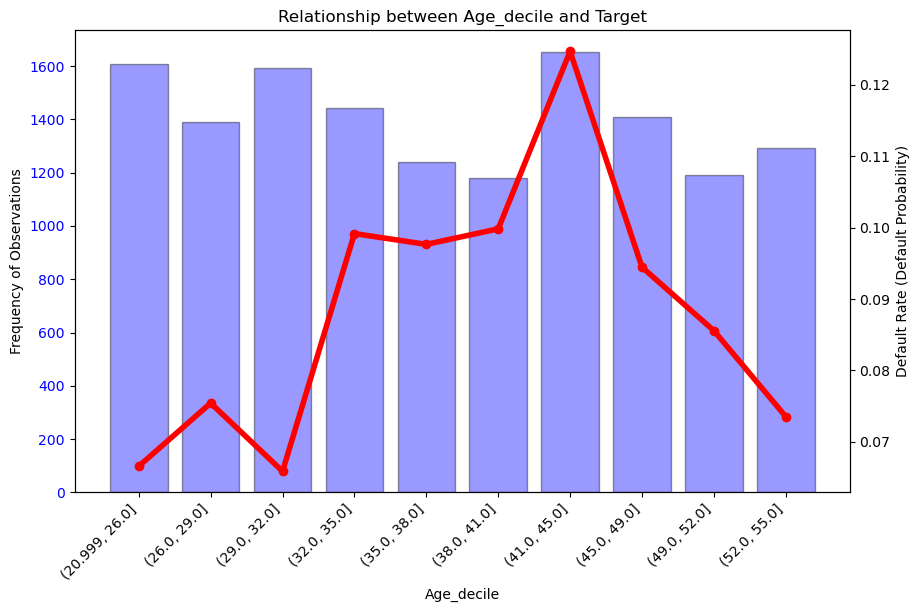

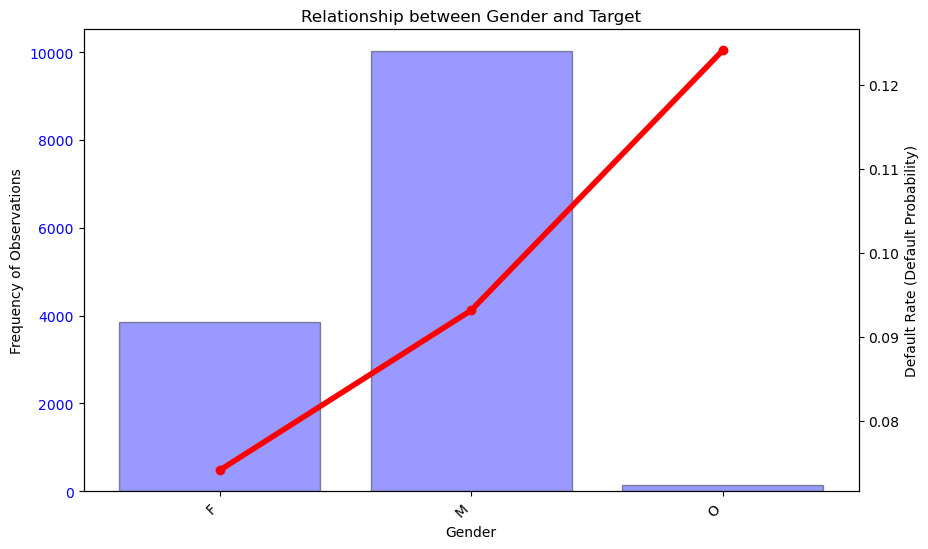

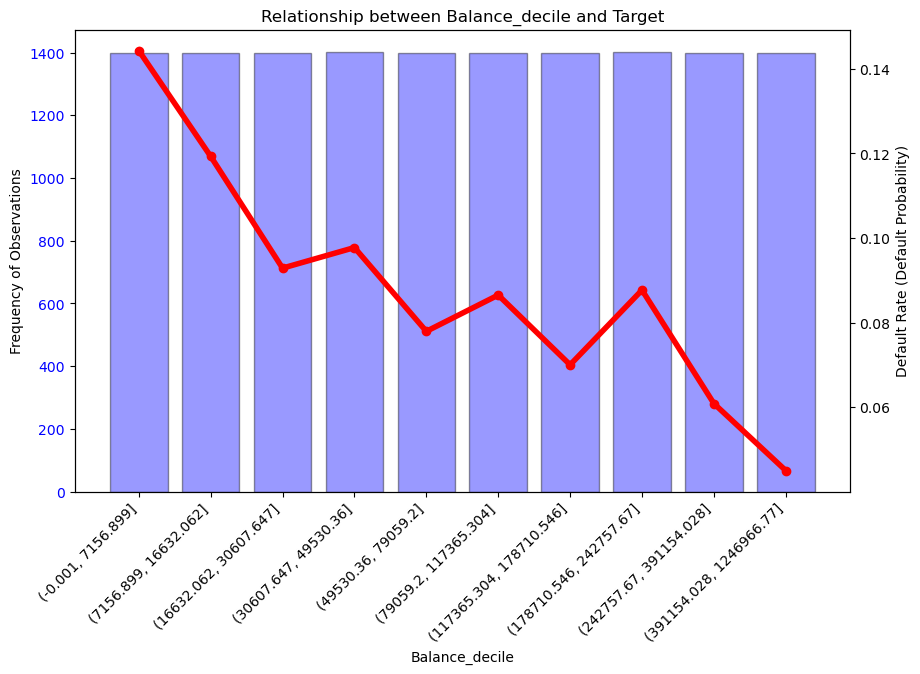

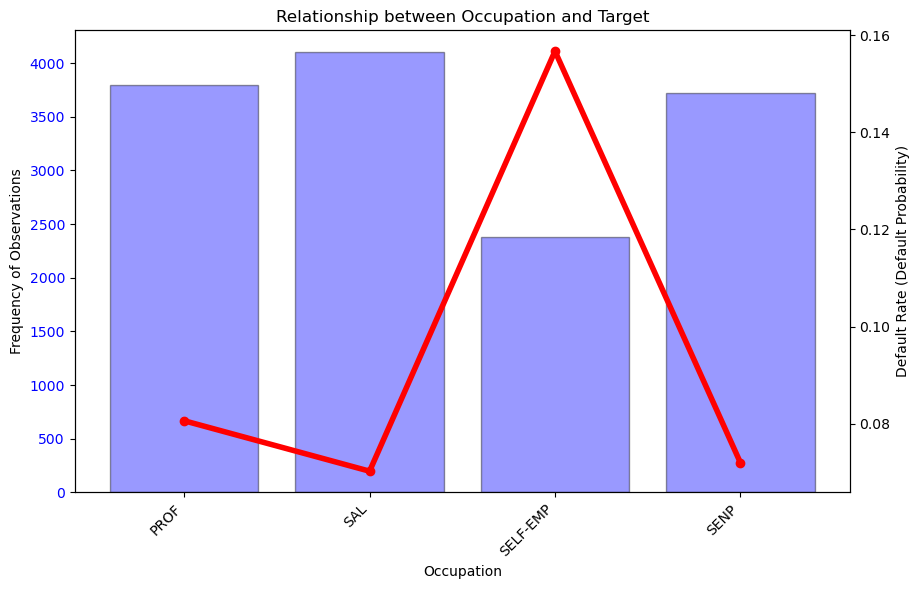

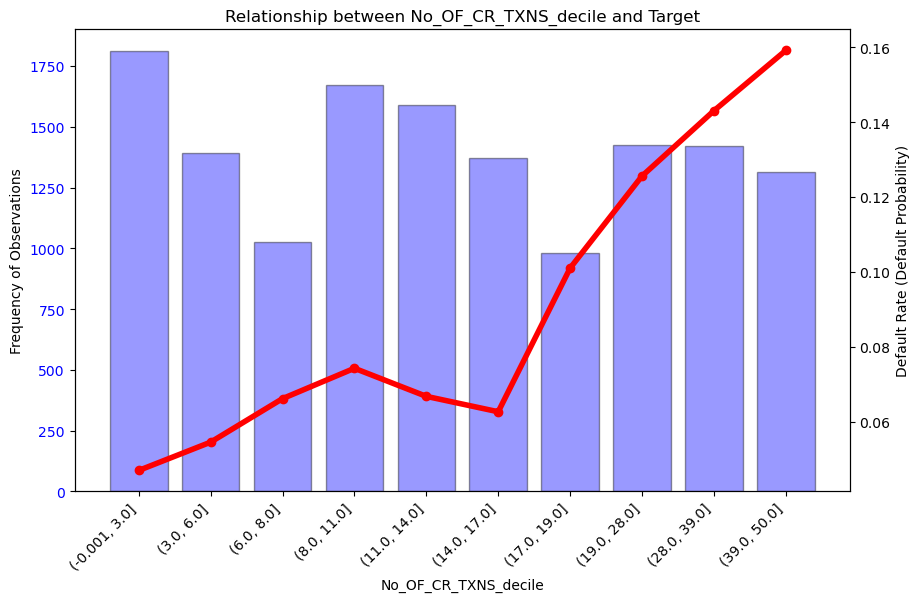

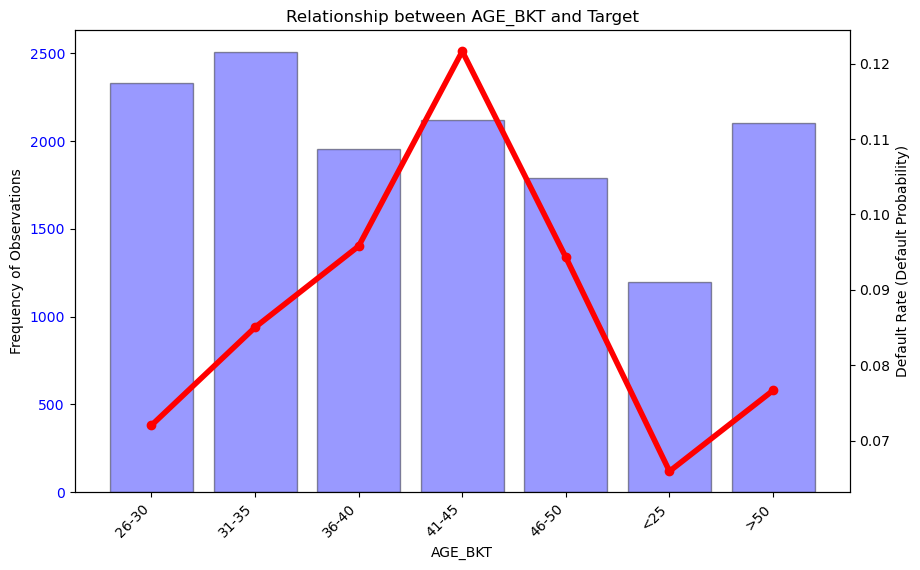

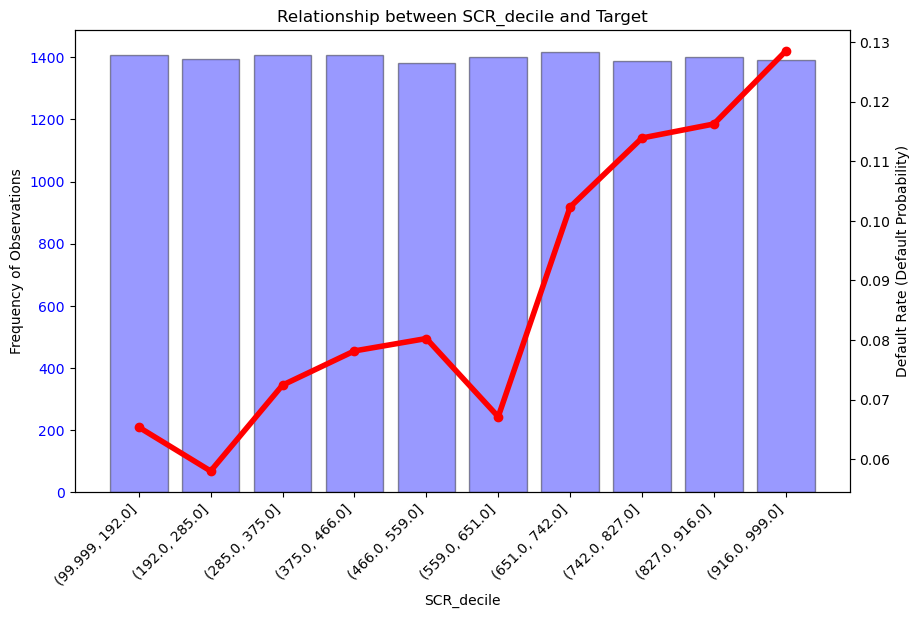

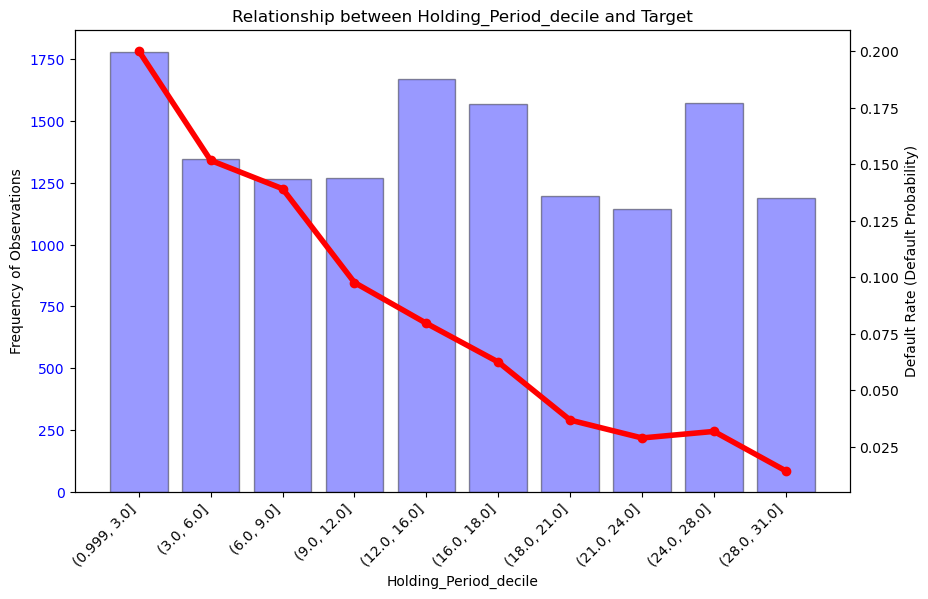

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FixedLocator

# Step 1: Import data from file
file_path = 'DEV_Sample.csv'
LR_DF = pd.read_csv(file_path)

# Step 2: Cust_ID is the Identifier Column
LR_DF = LR_DF.drop(columns=['Cust_ID'])

# Function to create deciles for continuous variables
def create_deciles(df, column):
    df[f'{column}_decile'] = pd.qcut(df[column], 10, duplicates='drop')
    return df

# Function to plot double axis chart
def plot_double_axis_chart(df, column, target):
    if pd.api.types.is_numeric_dtype(df[column]):
        df = create_deciles(df, column)
        column = f'{column}_decile'

    # Calculate frequency and default rate
    freq = df[column].value_counts().sort_index()
    default_rate = df.groupby(column, observed=True)[target].mean() # observed=True

    # Create figure and twin axis
    fig, ax1 = plt.subplots(figsize=(10, 6))
    # Create secondary y-axis and plot default rate
    ax2 = ax1.twinx()
    
    # Plot frequency on primary y-axis
    # Correction to ChatGPT code
    # sns.barplot(x=freq.index, y=freq.values, ax=ax1, color='skyblue')
    ax1.bar(freq.index.astype(str).to_numpy(), freq.values, color='blue', edgecolor="black", alpha=0.4, width=0.8)
    ax1.set_ylabel('Frequency of Observations')
    ax1.set_xlabel(column)
    ax1.tick_params(axis="y", labelcolor='blue')
    # Set tick labels manually to avoid warnings
    ax1.xaxis.set_major_locator(FixedLocator(range(len(freq.index))))
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

    
    # sns.lineplot(x=default_rate.index, y=default_rate.values, ax=ax2, color='red', marker='o')
    ax2.plot(freq.index.astype(str).to_numpy(), default_rate.values, color='red', lw=4, marker='o')
    ax2.set_ylabel('Default Rate (Default Probability)')
    
    plt.title(f'Relationship between {column} and {target}')
    plt.show()

# List of independent variables
independent_vars = ['Age', 'Gender', 'Balance', 'Occupation', 'No_OF_CR_TXNS', 'AGE_BKT', 'SCR', 'Holding_Period']

# Generate plots for each independent variable
for var in independent_vars:
    plot_double_axis_chart(LR_DF, var, 'Target')


### Visualization using SweetViz Package

In [8]:
# pip install sweetviz
import sweetviz as sv
report = sv.analyze([LR_DF, 'Train'], target_feat='Target')

                                             |                            | [  0%]   00:00 -> (? left)

In [9]:
#display the report
report.show_html('Visualization.html')

Report Visualization.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


### Thank you

In [1]:

import pandas as pd

# Load the dataset
data = pd.read_csv('DEV_Sample.csv')

# Display the first few rows to check the data
data.head()


,Cust_ID,Target,Age,Gender,Balance,Occupation,No_OF_CR_TXNS,AGE_BKT,SCR,Holding_Period
0,C16505,0,41,M,91519.92,SELF-EMP,38,41-45,926,15
1,C17241,0,52,M,117288.96,SAL,17,>50,768,13
2,C18802,0,31,F,259827.44,SENP,8,31-35,816,5
3,C19289,0,45,F,26677.55,PROF,14,41-45,353,18
4,C14028,0,39,F,43440.31,SENP,1,36-40,751,31


In [2]:
import numpy as np

def calc_iv(df, feature, target, bins=10):
    """
    Calculate IV (Information Value) for a continuous or categorical feature.
    :param df: DataFrame
    :param feature: Feature column name
    :param target: Target column name
    :param bins: Number of bins for continuous variables
    :return: IV value
    """
    lst = []
    for i in range(0, bins):
        min_val = df[feature].min()
        max_val = df[feature].max()
        range_val = (max_val - min_val) / bins
        lower = min_val + i * range_val
        upper = min_val + (i + 1) * range_val
        sub_df = df[(df[feature] >= lower) & (df[feature] < upper)]
        total = sub_df[target].count()
        positive = sub_df[target].sum()
        negative = total - positive
        if total == 0:
            continue
        rate_positive = positive / total
        rate_negative = negative / total
        woe = np.log(rate_positive / rate_negative) if rate_negative != 0 else 0
        iv = (rate_positive - rate_negative) * woe
        lst.append(iv)

    iv = sum(lst)
    return iv

# Calculate IV for all the features
features = ['Age', 'Gender', 'Balance', 'Occupation', 'No_OF_CR_TXNS', 'AGE_BKT', 'SCR', 'Holding_Period']
iv_dict = {feature: calc_iv(data, feature, 'Target') for feature in features}

# Display IV in a tabular format
iv_df = pd.DataFrame(list(iv_dict.items()), columns=['Feature', 'IV'])
iv_df.sort_values(by='IV', ascending=False, inplace=True)
print(iv_df)


TypeError: unsupported operand type(s) for -: 'str' and 'str'

C:\Users\rjakh\AppData\Local\Temp\ipykernel_24920\3854505527.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('bin')
C:\Users\rjakh\anaconda3\envs\PyEnv3117\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\rjakh\anaconda3\envs\PyEnv3117\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\rjakh\anaconda3

TypeError: Invalid object type at position 0

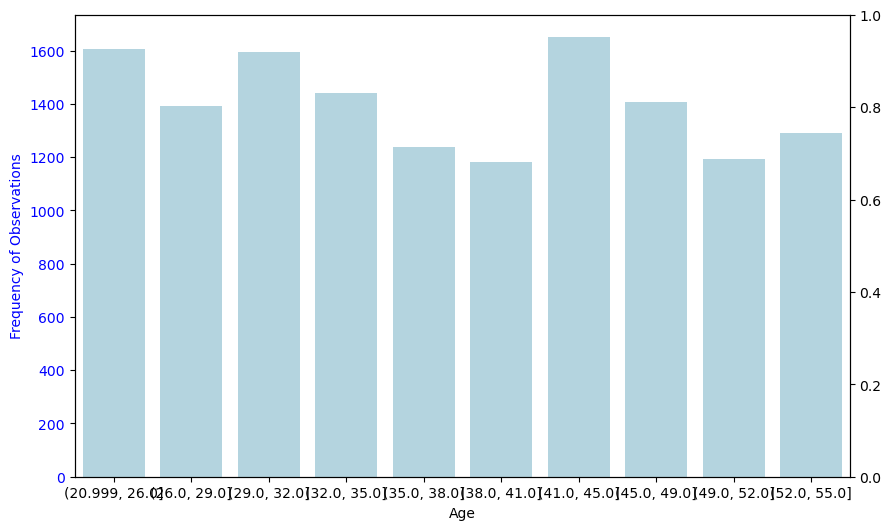

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def plot_double_axis(df, feature, target, bins=10):
    """
    Plot double-axis chart for the relationship between a feature and target variable.
    :param df: DataFrame
    :param feature: Feature column name
    :param target: Target column name
    :param bins: Number of bins for continuous variables
    """
    # Binning the continuous variable into deciles
    if np.issubdtype(df[feature].dtype, np.number):
        df['bin'] = pd.qcut(df[feature], bins, duplicates='drop')
    else:
        df['bin'] = df[feature]

    # Group by the binned/ categorical feature
    grouped = df.groupby('bin')
    frequency = grouped[target].count()
    default_rate = grouped[target].mean()
    
    # Plotting
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # Frequency plot
    sns.barplot(x=frequency.index, y=frequency.values, color='lightblue', ax=ax1)
    ax1.set_xlabel(feature)
    ax1.set_ylabel('Frequency of Observations', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    
    # Default rate plot on secondary y-axis
    ax2 = ax1.twinx()
    sns.lineplot(x=default_rate.index, y=default_rate.values, color='red', marker="o", ax=ax2)
    ax2.set_ylabel('Default Rate (Default Probability)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    # Title and layout adjustments
    plt.title(f'Relationship between {feature} and Target')
    plt.xticks(rotation=45)
    fig.tight_layout()
    plt.show()

    # Drop the bin column
    df.drop(columns=['bin'], inplace=True)


# Load the dataset
data = pd.read_csv('DEV_Sample.csv')

# Plot for a continuous variable (e.g., Age)
plot_double_axis(data, 'Age', 'Target', bins=10)

# Plot for a categorical variable (e.g., Occupation)
plot_double_axis(data, 'Occupation', 'Target', bins=10)


In [5]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [6]:
def plot_double_axis(df, feature, target, bins=10):
    """
    Plot double-axis chart for the relationship between a feature and target variable.
    :param df: DataFrame
    :param feature: Feature column name
    :param target: Target column name
    :param bins: Number of bins for continuous variables
    """
    # Binning the continuous variable into deciles
    if np.issubdtype(df[feature].dtype, np.number):
        df['bin'] = pd.qcut(df[feature], bins, duplicates='drop')
    else:
        df['bin'] = df[feature]

    # Group by the binned/categorical feature
    grouped = df.groupby('bin')
    frequency = grouped[target].count()
    default_rate = grouped[target].mean()
    
    # Plotting
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # Frequency plot
    sns.barplot(x=frequency.index.astype(str), y=frequency.values, color='lightblue', ax=ax1)
    ax1.set_xlabel(feature)
    ax1.set_ylabel('Frequency of Observations', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    
    # Default rate plot on secondary y-axis
    ax2 = ax1.twinx()
    sns.lineplot(x=default_rate.index.astype(str), y=default_rate.values, color='red', marker="o", ax=ax2)
    ax2.set_ylabel('Default Rate (Default Probability)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    # Title and layout adjustments
    plt.title(f'Relationship between {feature} and Target')
    plt.xticks(rotation=45)
    fig.tight_layout()
    plt.show()

    # Drop the bin column
    df.drop(columns=['bin'], inplace=True)



C:\Users\rjakh\AppData\Local\Temp\ipykernel_24920\220611049.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('bin')
C:\Users\rjakh\anaconda3\envs\PyEnv3117\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\rjakh\anaconda3\envs\PyEnv3117\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


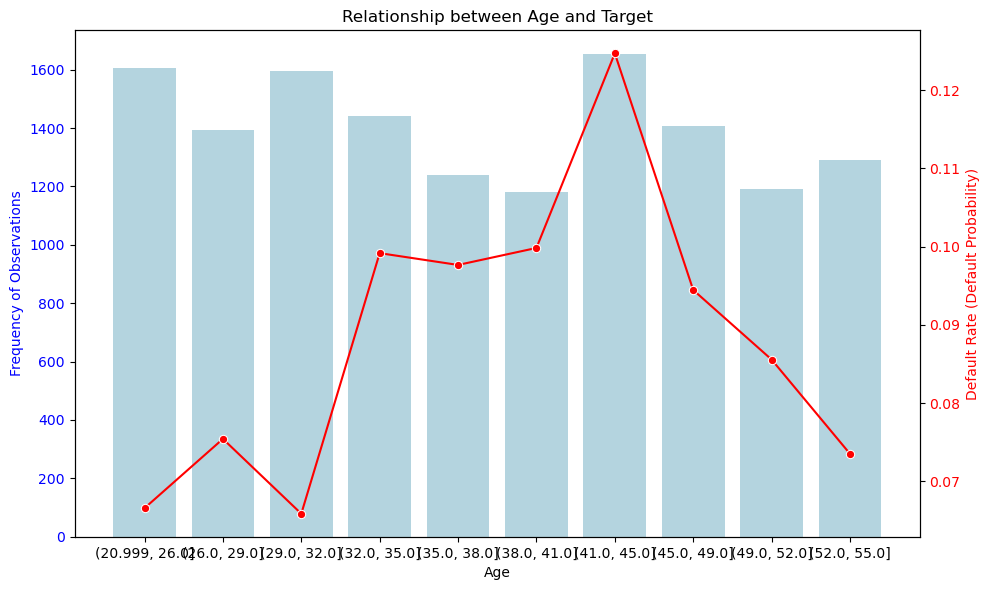

C:\Users\rjakh\anaconda3\envs\PyEnv3117\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\rjakh\anaconda3\envs\PyEnv3117\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


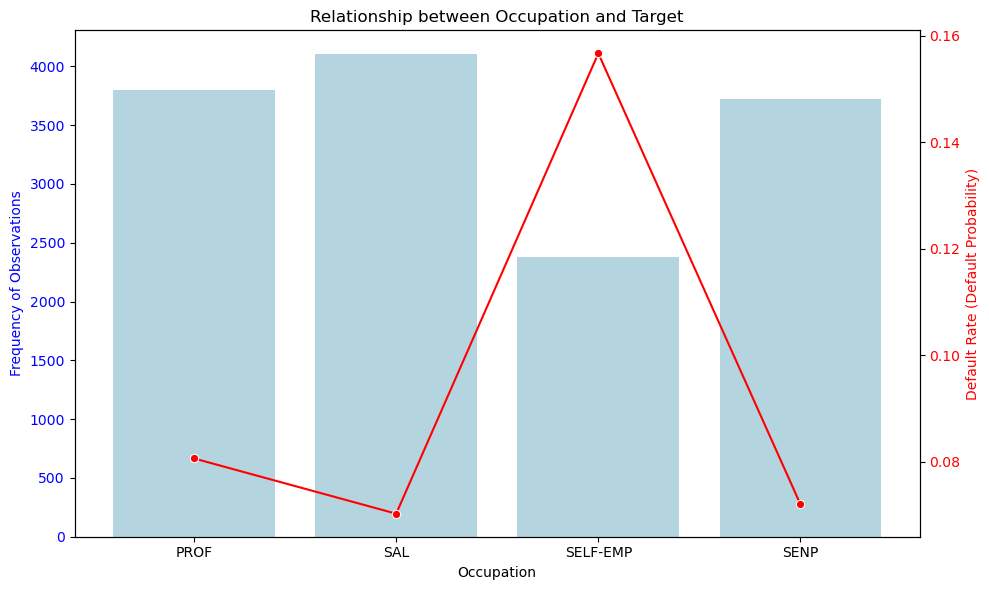

In [7]:
# Load the dataset
data = pd.read_csv('DEV_Sample.csv')

# Plot for a continuous variable (e.g., Age)
plot_double_axis(data, 'Age', 'Target', bins=10)

# Plot for a categorical variable (e.g., Occupation)
plot_double_axis(data, 'Occupation', 'Target', bins=10)
